Copyright (C) Egon Kidmose 2015-2018

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.

# Preprocessing CIC-IDS-2017 data #

 1. Import flow statistics with incident labels, as found in the orignal data.
 2. Run PCAPs found in original data through snort to obtain alerts (Not this file).
 3. Import alerts from snort log files.
 4. Label alerts by matching ip and port (This is work in progress).
 

In [1]:
from lstm_rnn_tied_weights import util
from lstm_rnn_tied_weights import snort

import pandas as pd
import numpy as np
import glob
from datetime import datetime
from datetime import timedelta
import cPickle as pickle
import os
import re

# matplotlib
try: # might, might not have x available
    import os
    os.environ['DISPLAY']
except KeyError:
    import matplotlib
    matplotlib.use('Agg')
try: # might, might not be notebook
    %matplotlib inline
except NameError:
    pass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/home/egk/git-reps/lstm-rnn-correlation/venv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
logger = util.get_logger('preprocessing-cic')

output_prefix = os.path.join('output', 'preprocessing-cic-'+util.get_runid(), util.get_runid()+'-')
if not os.path.exists('output'):
    os.mkdir('output')
if not os.path.exists(os.path.dirname(output_prefix)):
    os.mkdir(os.path.dirname(output_prefix))

seed = 1529911097 # Unix time at time of writing
def rndseed():
    global seed
    seed += 1
    return seed

Output prefix: log/preprocessing-cic-20180629-150523-egk-aau-laptop/20180629-150523-egk-aau-laptop-


## Load flow data from CSV ##

In [3]:
# Verify existing
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/; find  -iname '*.md5' -print0 | sort -z | xargs -0 -n1 bash -c 'cat ${0}; md5sum --check ${0}'
# extract
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/; unzip -o CSVs.zip -d CSVs
# checksum extracted CSVs
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs; sha256sum *
# pandas can't parse u"Infinity" as a float. Replacing with u"inf". https://github.com/pandas-dev/pandas/issues/10065
!sed -i'' 's/,Infinity,/,Inf,/g' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# Remove spaces leading fields
!sed -i'' 's/, /,/g' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# Remove rows with fields empty
!sed -i'' '/^,\{84\}\s\?$/d' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# checksum extracted CSVs, with above changes
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs; sha256sum *

cat: bash: No such file or directory
md5sum: bash: No such file or directory
unzip:  cannot find or open CSVs.zip, CSVs.zip.zip or CSVs.zip.ZIP.
7f02d9378e99d7d38254f63b7a67a8e2906201bad9b90b3005608472c7ca5e50  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
84fb712c5215ad1865e6d83be31a9b9f99e65d7a9647bcf6810a6751fd611c16  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
69b1727ee3c0f4013388f42216aa39a62bef709c976b929c125a28bfdc7398a1  Friday-WorkingHours-Morning.pcap_ISCX.csv
64b51c2bb54699c4f1376a42a37bda27f43572d30efa006939253ae5cfe6bdad  Monday-WorkingHours.pcap_ISCX.csv
311b7c13f058828f4258ca31b9f2c06c9bd2d33a14e1fa5e2258769ae822aed1  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
a9b349a9c06b7b6af9dae17498bd60080c7397277ebe38caf757325462c5992b  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
bc8796f601622e434a639441f0b2755329caa176116a1d48105e64534ac865fe  Tuesday-WorkingHours.pcap_ISCX.csv
5328925029e5bf3537f1181d98bb9359309b4a4b1a007b7ab924c0d8d0b05eef 

In [4]:
# Load flow data from CSV
flows = pd.DataFrame()

for f in glob.glob('../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv'):
    logger.info(u"Loading %s .." % f)
    df = pd.read_csv(
        f,
        dtype={
            'External IP': 'S15',
        },
        usecols=[
            'Flow ID',
            'Source IP',
            'Source Port',
            'Destination IP',
            'Destination Port',
            'Protocol',
            'Timestamp',
            'Flow Duration',
            'Label',
            'Total Fwd Packets',
            'Total Backward Packets',
        ],
        encoding='cp1252',
    )
    logger.info(df.shape)
    df['File'] = os.path.basename(f)
    flows = pd.concat([flows, df])

Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Morning.pcap_ISCX.csv ..
(191033, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Monday-WorkingHours.pcap_ISCX.csv ..
(529918, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Tuesday-WorkingHours.pcap_ISCX.csv ..
(445909, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv ..
(170366, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv ..
(288602, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Wednesday-workingHours.pcap_ISCX.csv ..
(692703, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ..
(286467, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscx

In [5]:
# Parse timestamp
def strptime(s):
    """
    Parse timestamp, handling intermittent zero-padding and omission of seconds.
    """
    r = re.compile('^(?P<day>[0-9]{1,2})/(?P<month>[0-9]{1,2})/(?P<year>[0-9]{4}) (?P<hour>[0-9]{1,2}):(?P<minute>[0-9]{2})(?::(?P<second>[0-9]{2}))?(?P<remainder>.+)?$')
    m = r.match(s)
    if m is None:
        raise ValueError('No match on %s' % s)
    d = m.groupdict()
    if d['remainder'] is not None:
        raise ValueError('Remainder is not None for \'%s\': %s' % (s, str(d)))
    d.pop('remainder')
    if d['second'] is None:
        d.pop('second') # Seconds are optional
    return datetime(**{k: int(v) for k, v in d.items()})

assert strptime('7/7/2017 8:59') == datetime(2017, 7, 7, 8, 59) # No zeropad, no seconds
assert strptime('03/07/2017 08:55:58') == datetime(2017, 7, 3, 8, 55, 58) # Zeropad, seconds

flows.Timestamp = flows.Timestamp.map(strptime)

In [6]:
# Make Description
description = flows[['File', 'Label']].drop_duplicates().set_index(['File', 'Label'], drop=False).apply(
    lambda r: "%s (%s)" % (
        r[0].lower().replace('-workinghours', '').replace('.pcap_iscx.csv', ''), 
        r[1]
    ),
    axis=1
).rename('Description')
flows = flows.set_index(['File', 'Label']).join(description).reset_index()

In [7]:
# Parse Flow duration 
# By comparing 192.168.10.15:52772 <-> 1.1.70.73:80 TCP from pcap and csv => unit is microseconds
flows[u'Flow Duration'] = flows['Flow Duration'].map(
    lambda i: timedelta(seconds=float(i)/1e6)
)

In [8]:
# Calculate flow end
flows['TimestampEnd'] = flows['Timestamp'] + flows['Flow Duration']

In [9]:
# rename fields
column_mapper = {
    'Source IP': 'srcip',
    'Destination IP': 'dstip',
    'Source Port': 'srcport',
    'Destination Port': 'dstport',
    'Protocol': 'proto',
}
flows.columns = [column_mapper.get(c, c) for c in list(flows.columns)]

## Analyse flow data ##

/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise 

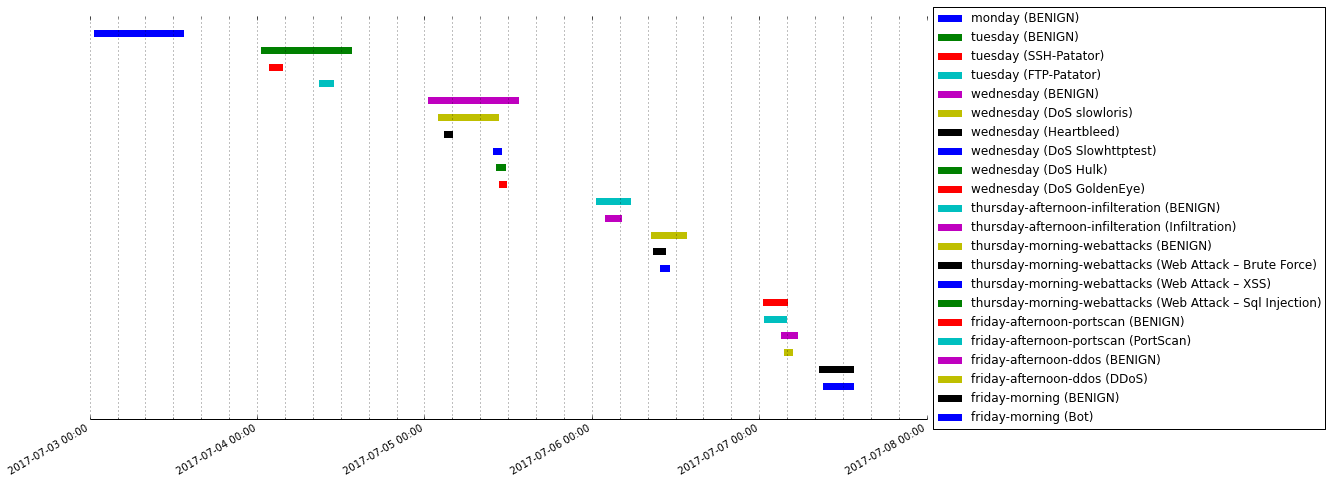

In [10]:
# Incident/series timespan plot

begin = flows.groupby('Description').Timestamp.min().sort_values()
end =  flows.groupby('Description').TimestampEnd.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

ax = df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    legend=True,
    figsize=(15, 8),
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
ax.grid(which='minor')
ax.set_xlim([
    np.datetime64(begin.min(), 'D'),
    np.datetime64(end.max(), 'D') + np.timedelta64(1, 'D'),
])

ax.yaxis.set_ticks_position('none')
ax.set_yticks([])

None

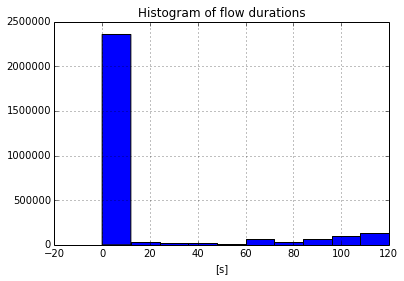

In [11]:
(flows['Flow Duration'] / pd.Timedelta(seconds=1)).hist()
plt.title("Histogram of flow durations")
plt.xlabel("[s]")

## Load snort alerts on PCAPs ##

In [12]:
# importing data
alertfiles = glob.glob('../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/*.pcap.out')
alerts = None

for fn in sorted(alertfiles):
    logger.debug('Loading %s' % fn)
    with open(fn) as f:
        df = pd.DataFrame(f.readlines(),columns=['line'])
        df = df.join(pd.DataFrame(
            map(snort.parse_line, df.line),
            columns=['ts', 'rid', 'msg', 'prio', 'proto', 'srcip', 'srcport', 'dstip', 'dstport'],
        ))
    alerts = pd.concat([alerts, df])
    logger.info("Loaded %d alerts from %s" % (len(df), fn,))
alerts.ts = alerts.ts + (datetime(2017, 1, 1) - datetime(1900, 1, 1)) # increment year to 2017
alerts = alerts.sort_values('ts').reset_index(drop=True)
# Some clock where off. -10hrs makes sense when looking at flow vs alerts for the heartbleed attack.
alerts.ts = alerts.ts # - pd.Timedelta(hours=10) 
NO_ALERTS = alerts.shape[0]
logger.info("All data loaded, %d total alerts" % NO_ALERTS)

Loaded 61491 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Friday-WorkingHours.pcap.out
Loaded 46530 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Monday-WorkingHours.pcap.out
Loaded 30237 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Thursday-WorkingHours.pcap.out
Loaded 34580 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Tuesday-WorkingHours.pcap.out
Loaded 259022 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Wednesday-workingHours.pcap.out
All data loaded, 431860 total alerts


In [13]:
# str to unicode
alerts.srcip = alerts.srcip.map(str.decode)
alerts.dstip = alerts.dstip.map(str.decode)
# parse port
alerts.srcport = alerts.srcport.fillna(0).astype(int)
alerts.dstport = alerts.dstport.fillna(0).astype(int)

## Merge alerts with labelled flows for labels ##

In [14]:
# Direction agnostic IP, port
alerts['ips'] = alerts[['srcip', 'dstip',]].apply(set, axis=1).apply(str)
alerts['ports'] = alerts[['srcport', 'dstport',]].apply(set, axis=1).apply(str)
flows['ips'] = flows[['srcip', 'dstip',]].apply(set, axis=1).apply(str)
flows['ports'] = flows[['srcport', 'dstport',]].apply(set, axis=1).apply(str)
# apply(set, ...).apply(str) - pandas says sets are unhashable, so can't join on them


In [16]:
# Join on alerts' index 
alerts = pd.DataFrame.join(
    alerts.reset_index().set_index(['ips', 'ports']),
    flows.reset_index().set_index(['ips', 'ports']),
    how='left',
    lsuffix='_alerts',
    rsuffix='_flows',
)
# del(flows)
alerts = alerts.set_index('index_alerts').sort_index()

In [17]:
logger.info("Number of alerts that doesn't join with a label: %d" % alerts.Label.isna().sum())

Number of alerts that doesn't join with a label: 58127


In [18]:
# Identify how much the alert ts outside the flow Timestamp

# How much is it outside?
alerts['ts_distance'] = pd.DataFrame(
    {
        'before': alerts.Timestamp - alerts.ts, # How much before
        'after': alerts.ts - alerts.TimestampEnd # How much after
    },
).max(axis=1)

# if it's actually inside, then it's zero:
alerts[(alerts.Timestamp < alerts.ts) & (alerts.ts < alerts.TimestampEnd)]['ts_distance'] = pd.Timedelta(0)


In [19]:
# Calculate per alert best distance in time
ts_distance_min = alerts.join(
    alerts.reset_index().groupby('index_alerts').ts_distance.min().rename('ts_distance_min')
).ts_distance_min

In [20]:
# Discard all but best distance for each alert
idx_best_ts = (alerts.ts_distance == ts_distance_min) # best ts matches, can be multiple
idx_no_join = alerts.ts_distance.isna() # Those that failed on the alert x flow join
alerts = alerts[idx_best_ts | idx_no_join]

In [21]:
#  Assume unjoined are benign
alerts.loc[alerts.ts_distance.isna(), 'Label'] = 'BENIGN'
alerts.loc[alerts.ts_distance.isna(), 'Description'] = 'BENIGN (Fail to join alerts x flows)'

In [22]:
alerts.shape

(432559, 26)

In [23]:
# count how many occurences of each label for each alerts due to alert<->flow ambiguity
label_counts = alerts[alerts.index.duplicated(keep=False)].reset_index().groupby(
    ['index_alerts', 'Label']).index_flows.count().unstack()
# Ensure that label count is non-zero for exactly one label per alert
assert ((label_counts > 0).sum(axis=1) == 1).all(), 'Labelling process is ambiguos'
# Drop duplicates
alerts = alerts[~alerts.index.duplicated()]

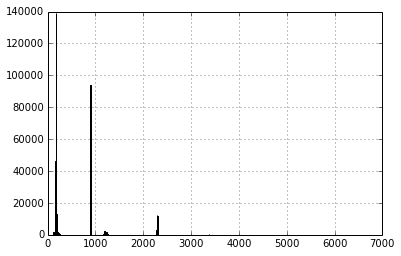

In [24]:
(alerts.ts_distance / pd.Timedelta(minutes=1)).hist(bins=500)

In [25]:
alerts.Label.value_counts()

BENIGN                        331085
DoS GoldenEye                  53557
DoS Hulk                       47070
Bot                              119
DDoS                              10
Web Attack – Sql Injection        10
SSH-Patator                        7
FTP-Patator                        2
Name: Label, dtype: int64

In [26]:
flows.Label.value_counts()

BENIGN                        2359289
DoS Hulk                       231073
PortScan                       158930
DDoS                            41835
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack – Brute Force         1507
Web Attack – XSS                  652
Infiltration                       36
Web Attack – Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

# A hell of a lot of plotting over time

fig, axes = plt.subplots(nrows=6, sharex=True)

# Incident/series timespan plot

begin = flows.groupby('Description').Timestamp.min().sort_values()
end =  flows.groupby('Description').TimestampEnd.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

ax = df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    figsize=(15, 16),
    ax=axes[0],
    legend=False,
)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
ax.grid(which='minor')
ax.set_xlim([
    np.datetime64(begin.min(), 'D'),
    np.datetime64(end.max(), 'D') + np.timedelta64(1, 'D'),
])

ax.yaxis.set_ticks_position('none')
ax.set_yticks([])

desc2color ={l.get_label(): l.get_color() for l in axes[0].get_lines()}

ax.set_title('Timespan of labels from flows')

# False alert timestamps binned
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count().index_alerts.rename('alerts')
ax = axes[1].bar(
    alert_bins.index,
    alert_bins,
    width=1./24, # x axis is float of days
)
axes[1].set_title('False alerts per hour')

# False alert timestamps binned - short y axis
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count().index_alerts.rename('alerts')
ax = axes[2].bar(
    alert_bins.index,
    alert_bins,
    width=1./24, # x axis is float of days
)
axes[2].set_title('False alerts per hour')
axes[2].set_ylim((0, 20000))

# Alert timestamps binned - By label
alert_bins = pd.DataFrame([
    desc #alerts[alerts.Description == desc].reset_index().set_index('ts').resample('1H').count().index_alerts.rename(desc)
    for desc in alerts.Description.unique()b

/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise 

(0, 10)

/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise 

/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise 

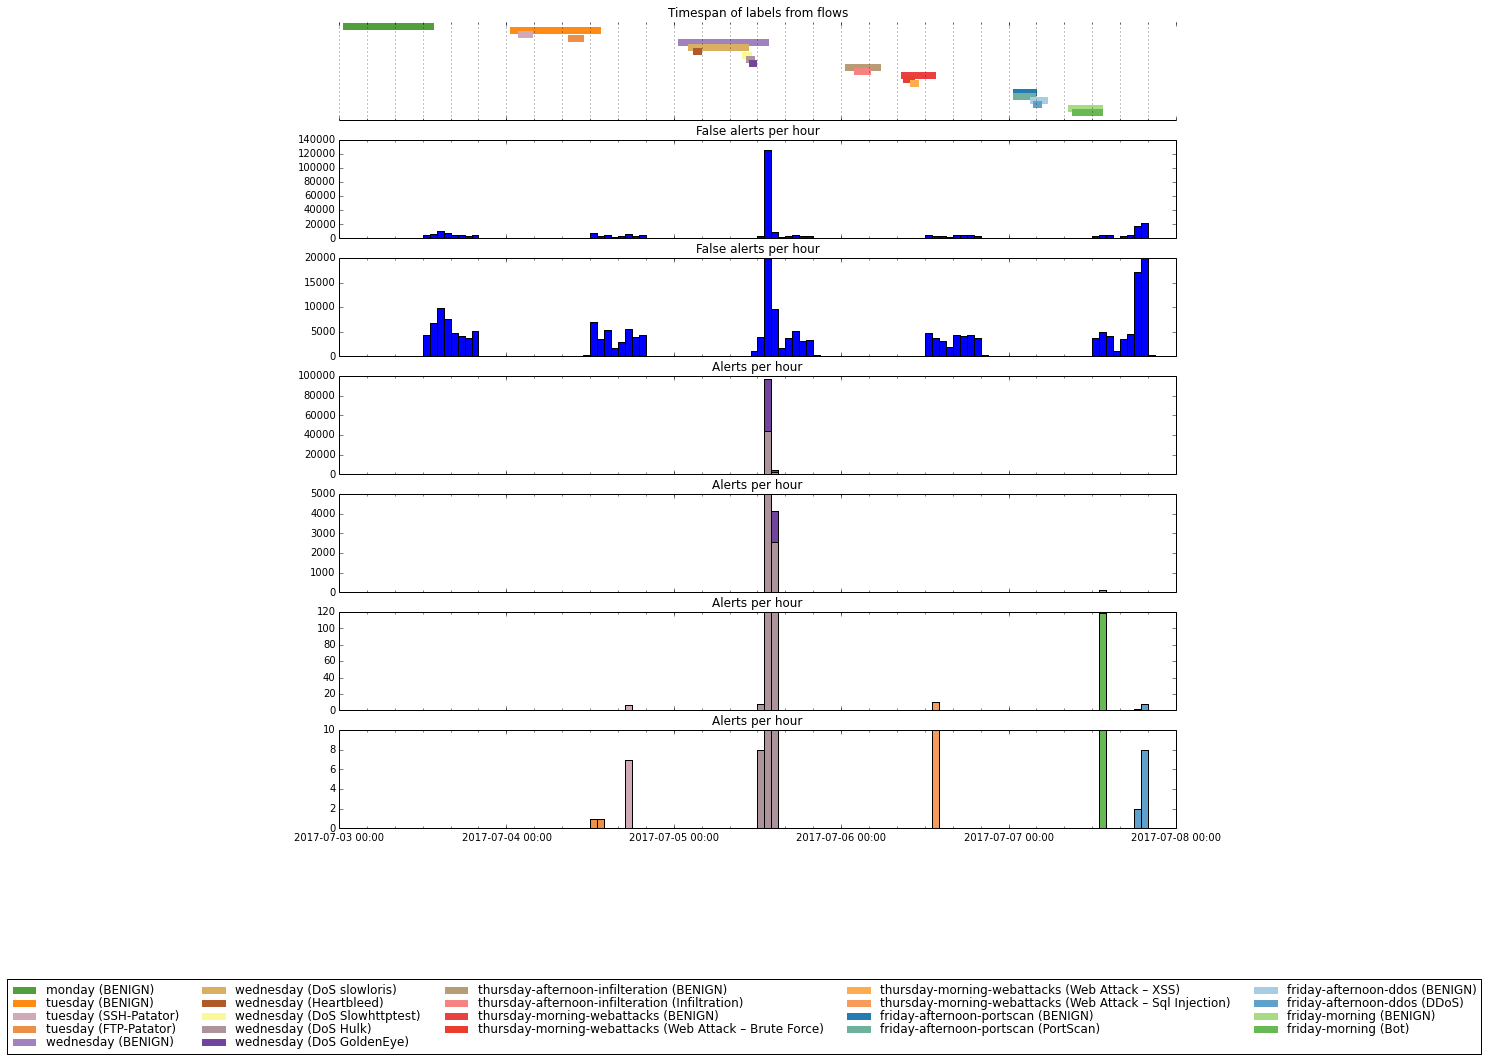

In [27]:
# A hell of a lot of plotting, by time

fig, axes = plt.subplots(nrows=7, sharex=True)
cdict = dict(zip(
    flows.Description.unique(),
    plt.cm.Paired(np.linspace(0, 1, len(flows.Description.unique())))
))

# Incident/series timespan plot

begin = flows.groupby('Description').Timestamp.min().sort_values()
end =  flows.groupby('Description').TimestampEnd.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

ax = df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    figsize=(15, 16),
    ax=axes[0],
    legend=False,
)
for l in ax.get_lines():
    l.set_color(cdict[l.get_label()])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))
ax.grid(which='minor')
ax.set_xlim([
    np.datetime64(begin.min(), 'D'),
    np.datetime64(end.max(), 'D') + np.timedelta64(1, 'D'),
])

ax.yaxis.set_ticks_position('none')
ax.set_yticks([])

plt.figlegend(
    axes[0].get_lines(), 
    [l.get_label() for l in axes[0].get_lines()], 
    loc = 'lower center', ncol=5, labelspacing=0.
)

ax.set_title('Timespan of labels from flows')

# False alert timestamps binned
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count().index_alerts.rename('alerts')
ax = axes[1].bar(
    alert_bins.index,
    alert_bins,
    width=1./24, # x axis is float of days
)
axes[1].set_title('False alerts per hour')

# False alert timestamps binned - short y axis
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count().index_alerts.rename('alerts')
ax = axes[2].bar(
    alert_bins.index,
    alert_bins,
    width=1./24, # x axis is float of days
)
axes[2].set_title('False alerts per hour')
axes[2].set_ylim((0, 20000))

# Alert timestamps binned - By label
alert_bins = pd.DataFrame([
    alerts[alerts.Description == desc].reset_index().set_index('ts').resample('1H').count().index_alerts.rename(desc)
    for desc in alerts.Description.unique() if 'BENIGN' not in desc
])

for ii, desc in enumerate(alert_bins.index):
    axes[3].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=cdict[desc],
    )
axes[3].set_title('Alerts per hour')

# Alert timestamps binned - By label - short y axis
for ii, desc in enumerate(alert_bins.index):
    axes[4].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=cdict[desc],
    )
axes[4].set_title('Alerts per hour')
axes[4].set_ylim((0, 5000))

# Alert timestamps binned - By label - shortER y axis
for ii, desc in enumerate(alert_bins.index):
    axes[5].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=cdict[desc],
    )
axes[5].set_title('Alerts per hour')
axes[5].set_ylim((0, 120))

# Alert timestamps binned - By label - shortER y axis
for ii, desc in enumerate(alert_bins.index):
    axes[6].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=cdict[desc],
    )
axes[6].set_title('Alerts per hour')
axes[6].set_ylim((0, 10))

In [28]:
alerts.groupby(alerts.ts.dt.floor('d')).ts.agg(['min', 'max']) # from 12:00 - 20:00 daily

,min,max
ts,,
2017-07-03,2017-07-03 11:56:38.033709,2017-07-03 20:01:34.197433
2017-07-04,2017-07-04 11:54:10.131438,2017-07-04 20:00:30.396898
2017-07-05,2017-07-05 11:42:48.583624,2017-07-05 20:10:14.560571
2017-07-06,2017-07-06 12:00:43.230429,2017-07-06 20:04:05.708469
2017-07-07,2017-07-07 12:00:35.357632,2017-07-07 20:02:39.808128


In [29]:
pd.DataFrame([
    flows.groupby(flows.Timestamp.dt.floor('d')).Timestamp.min().rename('min'),
    flows.groupby(flows.TimestampEnd.dt.floor('d')).Timestamp.max().rename('max'),
]).T # 01:00 - 11:00 daily

,min,max
2017-07-03,2017-07-03 01:00:01,2017-07-03 12:59:58
2017-07-04,2017-07-04 01:00:00,2017-07-04 12:59:00
2017-07-05,2017-07-05 01:00:00,2017-07-05 12:59:00
2017-07-06,2017-07-06 01:00:00,2017-07-06 12:59:00
2017-07-07,2017-07-07 01:00:00,2017-07-07 12:59:00


In [30]:
alerts.ts.max() - flows.Timestamp.max()

Timedelta('0 days 07:03:39.808128')

In [32]:
#cdict = dict(zip(
#    flows.Description.unique(),
#    plt.cm.Paired(
np.linspace(0, 1, len(flows.Description.unique()))#)
#))

array([ 0.        ,  0.04761905,  0.0952381 ,  0.14285714,  0.19047619,
        0.23809524,  0.28571429,  0.33333333,  0.38095238,  0.42857143,
        0.47619048,  0.52380952,  0.57142857,  0.61904762,  0.66666667,
        0.71428571,  0.76190476,  0.80952381,  0.85714286,  0.9047619 ,
        0.95238095,  1.        ])